# Introdução

Objetivo: Criar um modelo de aprendizado de máquina para prever se o cliente terá ou não crédito aprovado.

**Informações sobre o data set**

- **Loan_ID**: ID de empréstimo exclusivo.
- **Gender**: Gênero (masculino / feminino).
- **Married**: Casado (sim) ou Não casado (Não).
- **Dependents**: Número de pessoas dependendo do cliente.
- **Education**: Educação do Candidato (Graduado ou Não Graduado).
- **Self_Employed**: Autônomo (Sim/Não).
- **ApplicantIncome**: Renda do candidato.
- **CoapplicantIncome**: Renda do co-requerente.
- **LoanAmount**: Valor do empréstimo em milhares.
- **Loan_Amount_Term**: Prazos do empréstimo em meses.
- **Credit_History**: Se o histórico de crédito atende às diretrizes (Sim ou Não)
- **Property_Area**: Local de residência dos candidatos (zona urbana, semi-urbana ou rural)
- **Loan_Status**: Empréstimo aprovado (S/N).

## Importação dos pacotes

In [121]:
# Importação dos pacotes para importação, manipulação e visualização dos dados
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
%matplotlib inline
import seaborn as sns

# Configurações de warnings e tabelas
sns.set_style('darkgrid')
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Carregamento dos pacotes para pré processamento e machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Importação da base de dados

In [123]:
# Importação do dataset
df = pd.read_csv(r"C:\Users\glauber.lima\Desktop\Glauber\5-projetos\5-MACHINE_LEARNING\1-CLASSIFICACAO\1-EMPRESTIMO\loan_data.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [124]:
# Dimensão
df.shape

(381, 13)

In [125]:
# Informações gerais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [126]:
# Checando duplicidade
df.duplicated().sum()

np.int64(0)

In [127]:
# Verificando valores ausentes
df.isna().sum().sort_values(ascending=False)

Credit_History       30
Self_Employed        21
Loan_Amount_Term     11
Dependents            8
Gender                5
Education             0
Married               0
Loan_ID               0
ApplicantIncome       0
LoanAmount            0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [128]:
# Removendo a coluna ID e renomeando as demais colunas
df.drop(columns='Loan_ID', inplace = True)
df.columns = ['genero','estado_civil','qtd_dependentes','escolaridade','autonomo','renda_requerente','renda_corequerente','valor_emprestimo','tempo_emprestimo','historico_credito','propriedade','status']

In [129]:
# Separando variaveis por tipo de dado
numericas = df.select_dtypes(include=['int64','float64']).columns.to_list()
categoricas = df.select_dtypes(include=['object']).columns.to_list()
print("Numéricas: ",numericas)
print("Categóricas: ",categoricas)

Numéricas:  ['renda_requerente', 'renda_corequerente', 'valor_emprestimo', 'tempo_emprestimo', 'historico_credito']
Categóricas:  ['genero', 'estado_civil', 'qtd_dependentes', 'escolaridade', 'autonomo', 'propriedade', 'status']


In [130]:
# Visualizando valores categoricos
for c in categoricas:
    print(df[c].value_counts())
    print('-'*50)

genero
Male      291
Female     85
Name: count, dtype: int64
--------------------------------------------------
estado_civil
Yes    228
No     153
Name: count, dtype: int64
--------------------------------------------------
qtd_dependentes
0     234
2      59
1      52
3+     28
Name: count, dtype: int64
--------------------------------------------------
escolaridade
Graduate        278
Not Graduate    103
Name: count, dtype: int64
--------------------------------------------------
autonomo
No     325
Yes     35
Name: count, dtype: int64
--------------------------------------------------
propriedade
Semiurban    149
Urban        126
Rural        106
Name: count, dtype: int64
--------------------------------------------------
status
Y    271
N    110
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
# Renomear variáveis categóricas
mapeamentos = {
    'genero': {'Male': 'Masculino', 'Female': 'Feminino'},
    'estado_civil': {'Yes':'Sim', 'No': 'Não'},
    'qtd_dependentes': {'0': '0','1': '1','2': '2', '3+': '3 ou mais'},
    'escolaridade': {'Graduate': 'Graduado', 'Not Graduate': 'Não Graduado'},
    'autonomo': {'No': 'Não', 'Yes': 'Sim'},
    'propriedade': {'Semiurban': 'SemiUrbano','Urban': 'Urbano','Rural': 'Rural'},
    'status': {'Y': 'Sim', 'N': 'Não'}
}
df.replace(mapeamentos,inplace = True)
df.sample(5)

,genero,estado_civil,qtd_dependentes,escolaridade,autonomo,renda_requerente,renda_corequerente,valor_emprestimo,tempo_emprestimo,historico_credito,propriedade,status
241,Masculino,Sim,2,Graduado,Não,4566,0.0,100.0,360.0,1.0,Urbano,Não
166,Feminino,Não,0,Graduado,NaN,3418,0.0,135.0,360.0,1.0,Rural,Não
156,Masculino,Sim,0,Graduado,Não,1809,1868.0,90.0,360.0,1.0,Urbano,Sim
259,Masculino,Sim,0,Não Graduado,Não,2167,2400.0,115.0,360.0,1.0,Urbano,Sim
310,Masculino,Não,0,Não Graduado,Não,2699,2785.0,96.0,360.0,NaN,SemiUrbano,Sim
143,Masculino,Não,0,Não Graduado,Não,3189,2598.0,120.0,NaN,1.0,Rural,Sim
167,Feminino,Não,1,Graduado,Não,2876,1560.0,90.0,360.0,1.0,Urbano,Sim
33,Masculino,Sim,1,Graduado,Não,5649,0.0,44.0,360.0,1.0,Urbano,Sim
305,Masculino,Sim,3 ou mais,Não Graduado,Não,3095,0.0,113.0,360.0,1.0,Rural,Sim
328,Feminino,Não,0,Não Graduado,Não,3400,0.0,95.0,360.0,1.0,Rural,Não


In [132]:
# Distribuição da variável alvo
print(df['status'].value_counts())
print('-'*50)
print((df['status'].value_counts(normalize=True)*100).round(2))

status
Sim    271
Não    110
Name: count, dtype: int64
--------------------------------------------------
status
Sim    71.13
Não    28.87
Name: proportion, dtype: float64


Perceba que a base está desbalanceada, ou seja, tiveram mais pessoas que tiveram o empréstimo aprovado do que pessoas que não tiveram o empréstimo aprovado.

In [133]:
# Tempo emprestimo
df.tempo_emprestimo.value_counts().sort_values(ascending=False)

tempo_emprestimo
360.0    312
180.0     29
480.0     11
300.0      7
120.0      3
84.0       3
240.0      2
60.0       1
12.0       1
36.0       1
Name: count, dtype: int64

Perceba que a variável 'tempo_emprestimo' se encontra com a distribuição amplamente assimétrica. Com a maioria do tempo sendo 360 meses e a os demais sendo distribuídos em outros períodos de tempo de empréstimo.

In [134]:
# Resumo estatístico
df.describe()

,renda_requerente,renda_corequerente,valor_emprestimo,tempo_emprestimo,historico_credito
count,381.000000,381.000000,381.000000,370.000000,351.000000
mean,3579.845144,1277.275381,104.986877,340.864865,0.837607
std,1419.813818,2340.818114,28.358464,68.549257,0.369338
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2600.000000,0.000000,90.000000,360.000000,1.000000
50%,3333.000000,983.000000,110.000000,360.000000,1.000000
75%,4288.000000,2016.000000,127.000000,360.000000,1.000000
max,9703.000000,33837.000000,150.000000,480.000000,1.000000


Ao analisar a tabela de resumo, nota-se que há a presença de outliers e a distribuição das variáveis numéricas é assimétrica. Na variável 'tempo_emprestimo' já foi constatado na análise acima; a variável 'historico_credito' é categórica, portanto não será analisada nessa etapa. Para checar outliers e assimetria das distribuições, faremos uma análise gráfica para confirmar as suspeitas.

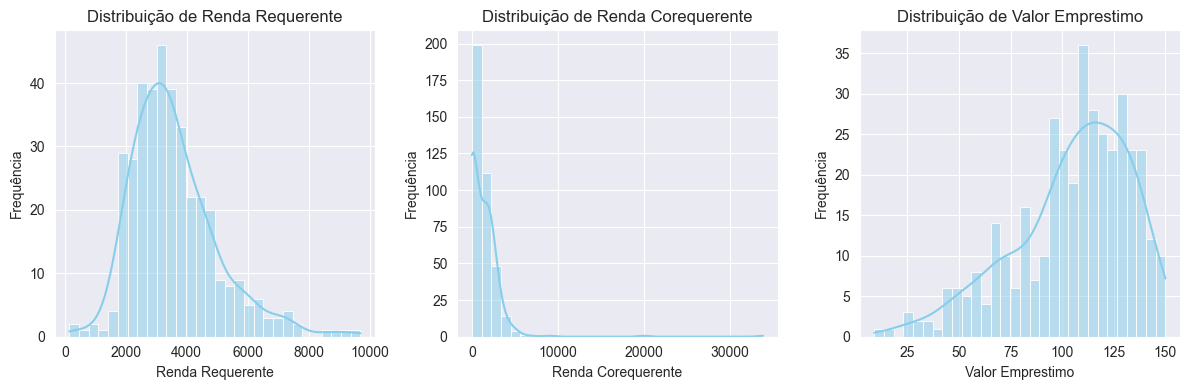

In [135]:
# Verificando a distribuição de renda do requerente, renda do corequerente e valor do emprestimo
atributos = ['renda_requerente','renda_corequerente','valor_emprestimo']
fig, ax = mpl.subplots(1,3,figsize = (12,4))
for i,c in enumerate(atributos):
    sns.histplot(data=df, x=c, bins=30, kde=True, ax=ax[i], color='skyblue')
    ax[i].set_title(f'Distribuição de {c.replace('_',' ').title()}')
    ax[i].set_xlabel(c.replace('_', ' ').title())
    ax[i].set_ylabel('Frequência')

mpl.tight_layout()
mpl.show()

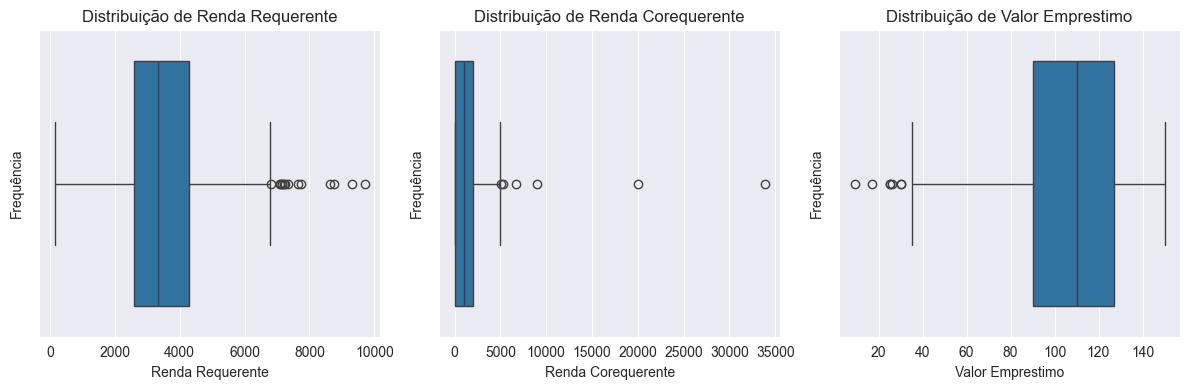

In [136]:
# Verificando o boxplot de renda do requerente, renda do corequerente e valor do emprestimo
fig, ax = mpl.subplots(1,3,figsize = (12,4))
for i,c in enumerate(atributos):
    sns.boxplot(data=df, x=c, ax=ax[i])
    ax[i].set_title(f'Distribuição de {c.replace('_',' ').title()}')
    ax[i].set_xlabel(c.replace('_', ' ').title())
    ax[i].set_ylabel('Frequência')

mpl.tight_layout()
mpl.show()

A análise gráfica confirma as suspeitas sobre a assimetria nas distribuições das variáveis numéricas e presença de valores extremos. Por ora, manteremos como está os dados em razão do volume de dados e tratativas posteriores.

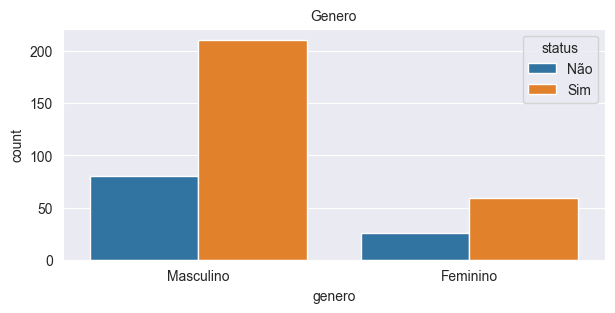

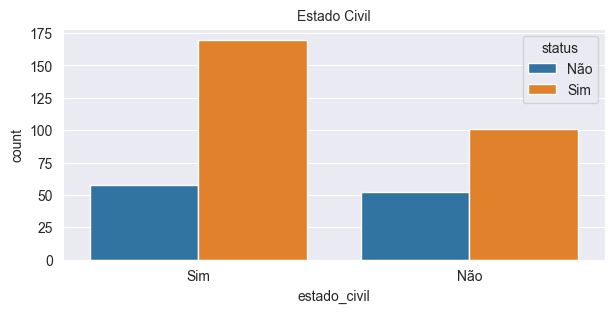

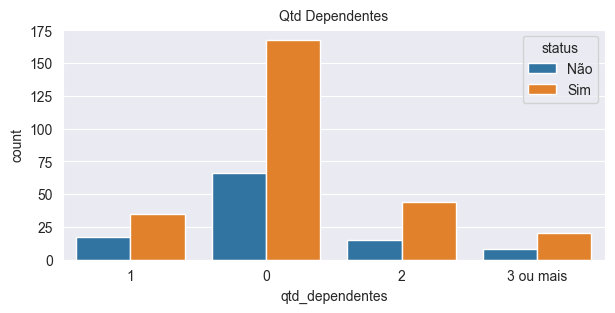

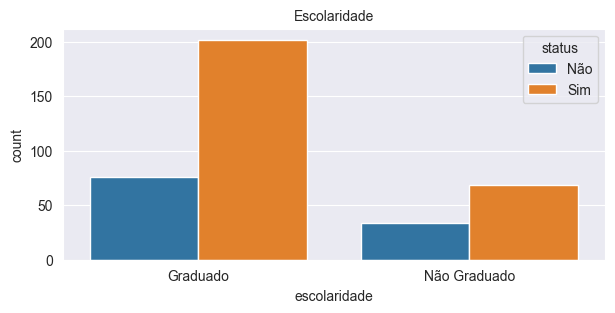

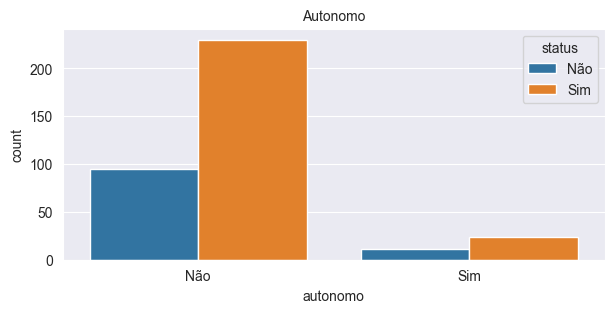

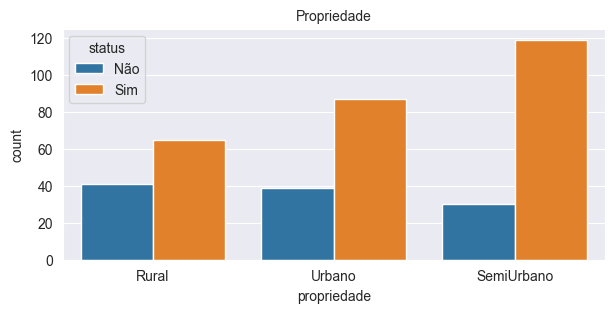

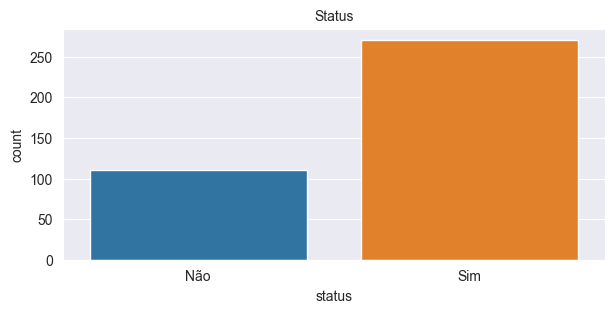

In [137]:
# Visualização gráfica das variáveis categóricas
for c in categoricas:
    mpl.figure(figsize = (7,3))
    mpl.title(c.replace('_',' ').title(), fontsize = 10)
    sns.countplot(x = df[c], hue = df['status'])

---

## Pré Processamento dos dados

In [138]:
# Visualizando novamente os dados
df.sample(5)

,genero,estado_civil,qtd_dependentes,escolaridade,autonomo,renda_requerente,renda_corequerente,valor_emprestimo,tempo_emprestimo,historico_credito,propriedade,status
219,Masculino,Sim,3 ou mais,Graduado,Não,2666,2083.0,95.0,360.0,1.0,Rural,Sim
66,Feminino,Sim,0,Graduado,Não,2484,2302.0,137.0,360.0,1.0,SemiUrbano,Sim
370,NaN,Não,0,Graduado,Não,4750,0.0,94.0,360.0,1.0,SemiUrbano,Sim
376,Masculino,Sim,3 ou mais,Graduado,Não,5703,0.0,128.0,360.0,1.0,Urbano,Sim
164,Masculino,Não,0,Graduado,Sim,5166,0.0,128.0,360.0,1.0,SemiUrbano,Sim


In [139]:
# Visualização dos valores ausentes
ausentes = df.isna().sum().sort_values(ascending = False).reset_index()
ausentes.columns = ['variavel','qtd']
ausentes['perc'] = round((ausentes['qtd'] / df.shape[0]) * 100,2)
ausentes = ausentes[ausentes.qtd > 0]
ausentes

,variavel,qtd,perc
0,historico_credito,30,7.87
1,autonomo,21,5.51
2,tempo_emprestimo,11,2.89
3,qtd_dependentes,8,2.10
4,genero,5,1.31


In [140]:
# Dropar os valores ausentes
df.dropna(inplace=True)

In [141]:
# Verificar distribuição da variável target após remover valores ausentes
print('Dimensão:',df.shape)
print(df.status.value_counts())

Dimensão: (308, 12)
status
Sim    219
Não     89
Name: count, dtype: int64


### Balanceamento de classes

Nessa etapa, iremos resolver o problema do desbalanceamento e, para isso, utilizaremos a técnica de undersampling. Isto é, removeremos parte dos valores da classe majoritária para se igualar ou ficar próximo da classe minoritária, garantindo que o modelo aprenda o padrão de forma igual para ambas as classes.

In [142]:
# Separar as bases
df_status_y = df[df['status'] == 'Sim']
df_status_n = df[df['status'] == 'Não']

In [143]:
# Preparação dos dados
df_status_y = df_status_y.sample(len(df_status_y)) # Embaralhar os dados
df_status_y_manter = df_status_y.sample(100) # Amostra de 100

In [144]:
# Juntar os data frames
df_final = pd.concat([df_status_y_manter,df_status_n])
df_final.shape

(189, 12)

In [145]:
# Verificando a distribuição da variável alvo
print(df_final['status'].value_counts())
print('-'*50)
print((df_final['status'].value_counts(normalize=True)*100).round(2))

status
Sim    100
Não     89
Name: count, dtype: int64
--------------------------------------------------
status
Sim    52.91
Não    47.09
Name: proportion, dtype: float64


In [146]:
# Dividir os dados em treino e teste
x = df_final.drop(columns='status', axis = 1)
y = df_final['status']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y,test_size=0.2,random_state=42)

In [147]:
# Atributos categoricos
atributos_cat = categoricas.copy()
atributos_cat.remove('status')
atributos_cat

['genero',
 'estado_civil',
 'qtd_dependentes',
 'escolaridade',
 'autonomo',
 'propriedade']

In [148]:
# Label encoder nas variáveis categóricas
lb = LabelEncoder()
for c in atributos_cat:
    lb.fit(x_treino[c])
    x_treino[c] = lb.transform(x_treino[c])
    x_teste[c] = lb.transform(x_teste[c])

In [149]:
# Checando os tipos de dados
print("Tipos dos dados de treino: ",x_treino.dtypes.unique())
print("Tipos dos dados de teste: ",x_teste.dtypes.unique())

Tipos dos dados de treino:  [dtype('int64') dtype('float64')]
Tipos dos dados de teste:  [dtype('int64') dtype('float64')]


In [150]:
# Padronizar as variáveis numéricas (usaremos MinMaxScaler)
mms = MinMaxScaler()
mms.fit(x_treino)
x_treino_final = mms.transform(x_treino)
x_teste_final = mms.transform(x_teste)

In [ ]:
# Convertendo a variável target em numérica
y_treino.replace({'Sim':1, 'Não': 0}, inplace=True)
y_teste.replace({'Sim':1, 'Não': 0}, inplace=True)

---

## Modelagem Preditiva

### Seleção de Features

Como não sabemos quais variáveis são as mais importantes para determinar o status do empréstimo, antes de irmos para a etapa de modelagem, iremos realizar a etapa de feature selection (seleção de variáveis). Para isso, utilizaremos o algoritmo Random Forest que possui um método 'importances' para definir quais as variáveis mais relevantes a serem levadas para a etapa de modelagem.

In [153]:
# Criar o classificador
rf = RandomForestClassifier()

In [155]:
# Treinar o classificador
rf.fit(x_treino_final, y_treino)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Definindo quais as variáveis mais relevantes
importancias = rf.feature_importances_
df_importancias = pd.DataFrame({'feature': x_treino.columns, 'importancia':importancias.round(5)*100})
df_importancias.sort_values(by = 'importancia', ascending=False)

,feature,importancia
9,historico_credito,24.216
7,valor_emprestimo,20.207
5,renda_requerente,19.605
6,renda_corequerente,10.100
10,propriedade,6.946
8,tempo_emprestimo,4.530
2,qtd_dependentes,4.401
1,estado_civil,3.021
0,genero,2.954
3,escolaridade,2.525


In [172]:
# Selecionando as features:
df_x_treino_final = pd.DataFrame(x_treino_final, columns = x_treino.columns)
df_x_teste_final = pd.DataFrame(x_teste_final, columns = x_teste.columns)

Para a seleção de feature, iremos selecionar as features que tiveram score de importância superior a 5. Portanto, selecionaremos as variáveis: 'historico_credito', 'valor_emprestimo', 'renda_requerente', 'renda_corequerente' e 'propriedade'.

In [ ]:
# Seleção de features
x_treino_final = df_x_treino_final[['historico_credito','valor_emprestimo','renda_requerente','renda_corequerente','propriedade']].values
x_teste_final = df_x_teste_final[['historico_credito','valor_emprestimo','renda_requerente','renda_corequerente','propriedade']].values

### Modelos e Validação

In [178]:
# Treino e avaliação dos modelos
models = {'Random Forest': RandomForestClassifier(),
          'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Ada Boost': AdaBoostClassifier(),
          'KNN': KNeighborsClassifier()
          }


Modelo:  Random Forest

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        18
           1       0.74      0.85      0.79        20

    accuracy                           0.76        38
   macro avg       0.77      0.76      0.76        38
weighted avg       0.77      0.76      0.76        38


--- CONFUSION MATRIX ---


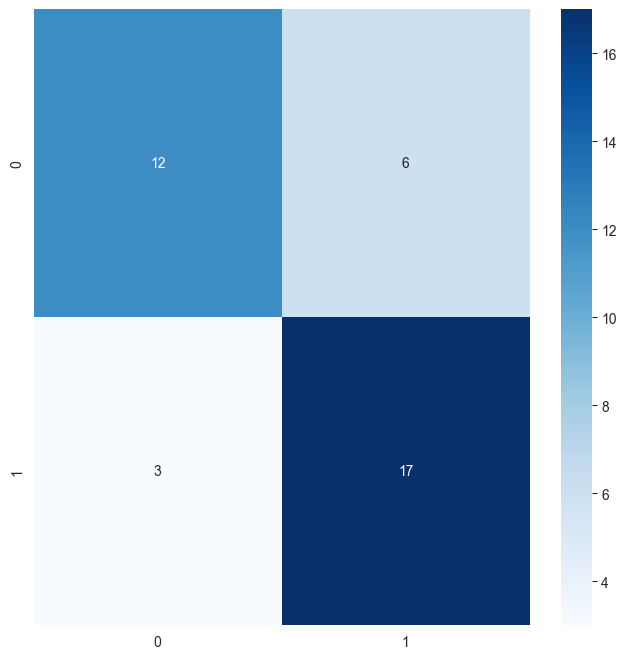


Modelo:  Logistic Regression

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        18
           1       0.69      1.00      0.82        20

    accuracy                           0.76        38
   macro avg       0.84      0.75      0.74        38
weighted avg       0.84      0.76      0.75        38


--- CONFUSION MATRIX ---


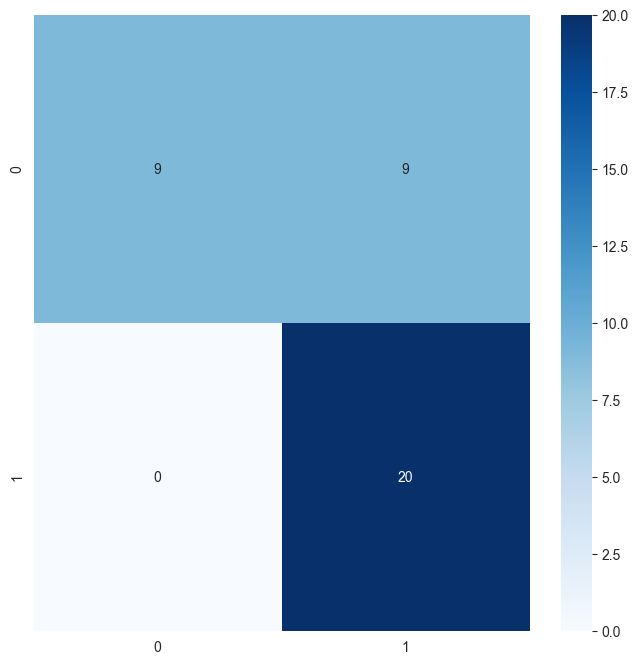


Modelo:  Decision Tree

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        18
           1       0.72      0.65      0.68        20

    accuracy                           0.68        38
   macro avg       0.69      0.69      0.68        38
weighted avg       0.69      0.68      0.68        38


--- CONFUSION MATRIX ---


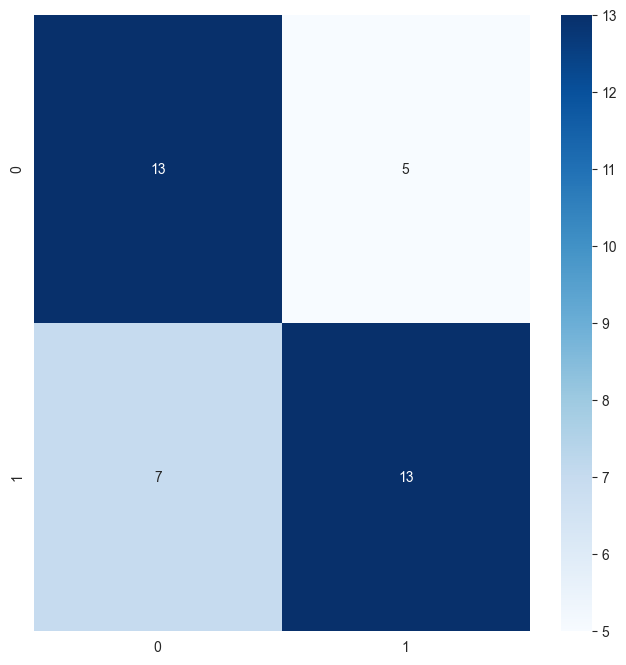


Modelo:  Ada Boost

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.83      0.95      0.88        20

    accuracy                           0.87        38
   macro avg       0.88      0.86      0.87        38
weighted avg       0.88      0.87      0.87        38


--- CONFUSION MATRIX ---


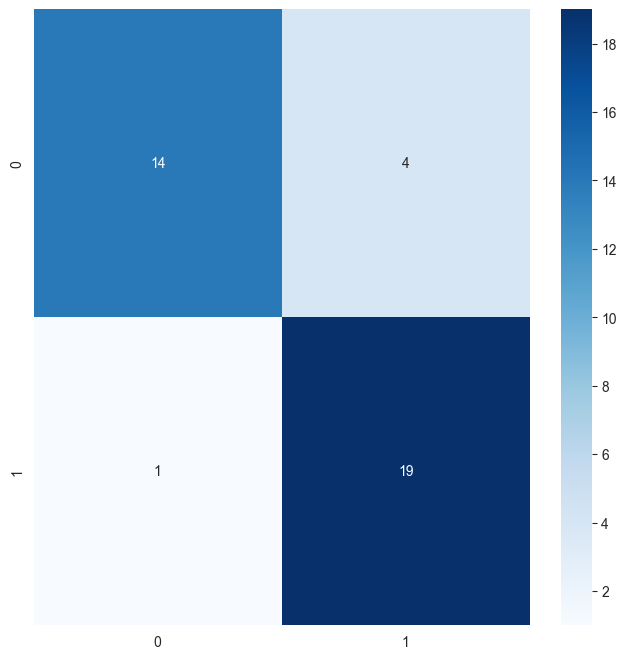


Modelo:  KNN

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.71      0.75      0.73        20

    accuracy                           0.71        38
   macro avg       0.71      0.71      0.71        38
weighted avg       0.71      0.71      0.71        38


--- CONFUSION MATRIX ---


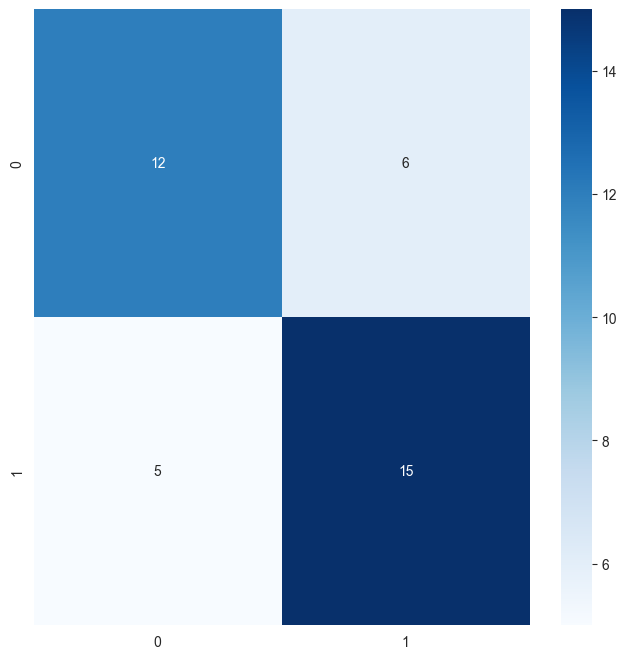

In [ ]:
# Loop para checar os resultados e a performance dos modelos
results = []
for name, model in models.items():
    model.fit(x_treino_final, y_treino)
    # predicao treino
    preds_treino = model.predict(x_treino_final)
    acc_treino = accuracy_score(y_treino, preds_treino)
    auc_treino = roc_auc_score(y_treino, preds_treino)
    results.append({'Modelo': name, 'Tipo': 'Treino', 'Acuracia': acc_treino, 'AUC': auc_treino})
    # predicao teste
    preds_teste = model.predict(x_teste_final)
    acc_teste = accuracy_score(y_teste, preds_teste)
    auc_teste = roc_auc_score(y_teste, preds_teste)
    results.append({'Modelo': name, 'Tipo': 'Teste', 'Acuracia': acc_teste, 'AUC': auc_teste})
    print('\nModelo: ',name)
    print('\n--- CLASSIFICATION REPORT ---')
    print(classification_report(y_teste, preds_teste))
    print('\n--- CONFUSION MATRIX ---')
    confusao = confusion_matrix(y_teste, preds_teste)
    mpl.figure(figsize = (5,5))
    sns.heatmap(confusao, annot = True, cmap = 'Blues')
    mpl.show()

In [194]:
# Dataframe dos resultados
df_resultados = pd.DataFrame(results)
df_resultados.sort_values(by=['Tipo','AUC'], ascending=[True, False])

,Modelo,Tipo,Acuracia,AUC
7,Ada Boost,Teste,0.868421,0.863889
1,Random Forest,Teste,0.763158,0.758333
3,Logistic Regression,Teste,0.763158,0.750000
9,KNN,Teste,0.710526,0.708333
5,Decision Tree,Teste,0.684211,0.686111
0,Random Forest,Treino,1.000000,1.000000
4,Decision Tree,Treino,1.000000,1.000000
6,Ada Boost,Treino,0.874172,0.869366
8,KNN,Treino,0.788079,0.781778
2,Logistic Regression,Treino,0.741722,0.726937


Escolhemos duas métricas para avaliar os modelos: Acurácia e AUC. A acurácia é uma métrica de validação que mensura a performance do modelo a partir da razão entre o número de previsões corretas e o total de previsões, isto é, a taxa de acerto do modelo. A métrica auc (Area Under the Curve - Área sob a curva) é uma métrica que quantifica a capacidade do modelo de distringuir entre classes positivas e negativas, quanto maior a métrica, melhor o modelo. Para esse caso, como estamos comparando a performance entre modelos, o ideal é utilizar a métrica AUC , uma vez que é independente do limiar de classificação.

Por meio do dataframe de resultados, escolheremos o algoritmo Ada Boost que obtecve desempenho semelhante entre treino e teste. Observe que os algoritmos de Árvore de Decisão e Floresta Aleatória apresentaram overfitting, sendo possível notar pela ótima performance nos dados de treino e queda brusca da performance nos dados de teste.

### Validação Cruzada e Otimização de Hiperparâmetros

Uma vez escolhido o modelo no formato vanilla, iremos realizar validação cruzada ao mesmo tempo que aplicaremos técnicas de otimização de hiperparâmetros com o objetivo de tentar aumentar a performance do modelo.

A validação cruzada é uma técnica capaz de avaliar a capacidade de gneralização do modelo, basicamente, os dados são divididos em subconjuntos, onde um subconjunto é separado para teste e os demais subconjuntos são usados para treinamento. Após isso, o modelo é aplicado em cada uma das partições e o score final é a média da performance do modelo em cada participação.

A otimização de hiperparâmetros se refere a o processo de ajustar as configurações de um algoritmo que controlam o processo de treinamento e que pode resultar em um algoritmo mais robusto e performático.

In [ ]:
# Aplicação  do Grid Search CV (Validação cruzada + Otimização de hiperparâmetros)
model = AdaBoostClassifier()
param_grid = {
    "n_estimators": [100, 300],
    "learning_rate": [0.05, 0.1, 0.5],
    
    # Novo nome do parâmetro: estimator (antes era base_estimator)
    "estimator": [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2)
    ],
    # Hiperparâmetros da árvore interna
    "estimator__min_samples_leaf": [1, 2]
}
grid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring = 'roc_auc', verbose = 1, n_jobs = -1)
grid.fit(x_treino_final, y_treino)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC...r(max_depth=1), DecisionTreeC...r(max_depth=2)], 'estimator__min_samples_leaf': [1, 2], 'learning_rate': [0.05, 0.1, ...], 'n_estimators': [100, 300]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
# Verificando a melhor combinação de hiperparâmetros e o score AUC
print("Melhores parâmetros:", grid.best_params_)
print("Melhor score CV:", grid.best_score_)

Melhores parâmetros: {'estimator': DecisionTreeClassifier(max_depth=2), 'estimator__min_samples_leaf': 2, 'learning_rate': 0.5, 'n_estimators': 300}
Melhor score CV: 0.7801190476190476


**Conclusão**

Perceba que a otimização de hiperparâmetros não melhorou a performance do modelo. Portanto, o ideal é utilizar o modelo no formato 'vanilla' com os hiperparâmetros default do algoritmo selecionado.